# Output Analysis

This notebook contains our analysis of the recommender evaluation results.

It proceeds in a few steps:

1. [Setup](#Setup), where we do the initial R configuration
2. [Read Data](#Read-Data), where we load in the experiment data for analysis
3. [Controlling for Profile Size](#Controlling-for-Profile-Size), where we model accuracy as a function of user profile size in order to control for intrinsic profile difficulty
4. [Gender](#Gender), where we analyze the results by gender.
5. [Age](#Age), where we analyze the results by age.

## Setup

Libraries:

In [2]:
library(MASS)
library(plyr)
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Options:

In [3]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

## Read Data

First, we need to read the user data from the underlying MovieLens data:

In [4]:
users.meta = read_delim("data/ml-1m/users.dat", delim=":",
                   col_names=c("user", "gender", "age", "occupation", "zip"),
                   col_types="i_c_c_c_c") %>%
    mutate(gender=as.factor(gender),
           age=as.factor(age),
           occupation=as.factor(occupation))
users.meta

user,gender,age,occupation,zip
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
⋮,⋮,⋮,⋮,⋮
6036,F,25,15,32603
6037,F,45,1,76006
6038,F,56,1,14706
6039,F,45,0,01060


Now, we want to get user profile statistics. In order to do that, we need each user's train profile; we can load that from the training data output by the cross-folding process.

For each partition, we need to load the _train ratings_ (historical profile) for all the _test users_ in that partition. So we will load the test data (to get the users) and the train data (to get the histories), then merge them.

In [5]:
train.ratings = ldply(1:5, function(part) {
    message("reading part ", part)
    test.fn = sprintf("build/ML-1M.out/part0%d.test.csv", part)
    train.fn = sprintf("build/ML-1M.out/part0%d.train.csv", part)
    test = suppressMessages(read_csv(test.fn, col_names=c("user", "item", "rating", "timestamp")))
    train = suppressMessages(read_csv(train.fn, col_names=c("user", "item", "rating", "timestamp")))
    test %>%
        select(user) %>%
        distinct() %>%
        mutate(part=as.factor(part), proto=as.factor('UserPct')) %>%
        inner_join(train)
})

reading part 1
Joining, by = "user"
reading part 2
Joining, by = "user"
reading part 3
Joining, by = "user"
reading part 4
Joining, by = "user"
reading part 5
Joining, by = "user"


Quick summary just to see what this data looks like:

In [6]:
train.ratings %>%
    select(part, proto, rating) %>%
    summary()

 part           proto            rating     
 1:200413   UserPct:970009   Min.   :1.000  
 2:204820                    1st Qu.:3.000  
 3:185240                    Median :4.000  
 4:191357                    Mean   :3.578  
 5:188179                    3rd Qu.:4.000  
                             Max.   :5.000  

Now we want to compute per-user profile statistics:

In [7]:
user.stats = train.ratings %>%
    group_by(user) %>%
    summarize(nratings = n(), meanRating=mean(rating), ratingVar=var(rating))
user.stats

user,nratings,meanRating,ratingVar
1,48,4.166667,0.4822695
2,124,3.717742,1.0009835
3,46,3.869565,0.9159420
4,16,4.062500,1.2625000
5,193,3.129534,1.2904253
⋮,⋮,⋮,⋮
6036,883,3.305776,1.0492523
6037,197,3.725888,0.7816223
6038,15,4.200000,0.6000000
6039,118,3.872881,0.5221643


Join these statistics with our user metadata table, so that we have one table of user information:

In [8]:
users = users.meta %>% inner_join(user.stats)
users

Joining, by = "user"


user,gender,age,occupation,zip,nratings,meanRating,ratingVar
1,F,1,10,48067,48,4.166667,0.4822695
2,M,56,16,70072,124,3.717742,1.0009835
3,M,25,15,55117,46,3.869565,0.9159420
4,M,45,7,02460,16,4.062500,1.2625000
5,M,25,20,55455,193,3.129534,1.2904253
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6036,F,25,15,32603,883,3.305776,1.0492523
6037,F,45,1,76006,197,3.725888,0.7816223
6038,F,56,1,14706,15,4.200000,0.6000000
6039,F,45,0,01060,118,3.872881,0.5221643


Now that we have user information, we can read the per-user recommender evaluation results.

In [9]:
user.results.all = read_csv("build/movielens-user-results.csv", guess_max=10000) %>%
    rename(user=User) %>%
    mutate(DataSet=as.factor(DataSet), 
           Partition=as.factor(Partition),
           Algorithm=as.factor(Algorithm)) %>%
    inner_join(users)
head(user.results.all)

Parsed with column specification:
cols(
  DataSet = col_character(),
  Partition = col_integer(),
  Algorithm = col_character(),
  User = col_integer(),
  TestTime = col_double(),
  RMSE = col_double(),
  Rank.nDCG = col_double(),
  nDCG = col_double(),
  Rank = col_integer(),
  RecipRank = col_double(),
  AvgPrec = col_double(),
  `1R.nDCG` = col_character(),
  `1R.Rank` = col_character(),
  `1R.RecipRank` = col_character(),
  `1R.AvgPrec` = col_character()
)
Joining, by = "user"


DataSet,Partition,Algorithm,user,TestTime,RMSE,Rank.nDCG,nDCG,Rank,RecipRank,⋯,1R.Rank,1R.RecipRank,1R.AvgPrec,gender,age,occupation,zip,nratings,meanRating,ratingVar
ML-1M.UI,4,Pop-B,4040,0.014,NA,1,0,NA,0,⋯,NA,NA,NA,M,25,20,75006,181,2.972376,1.4492327
ML-1M.UI,4,Pop-B,4041,0.007,NA,1,0,NA,0,⋯,NA,NA,NA,M,18,3,48005,839,3.313468,1.0340785
ML-1M.UI,3,Pop-B,4084,0.004,NA,1,0,NA,0,⋯,NA,NA,NA,M,56,13,14215,163,4.343558,0.5725971
ML-1M.UI,4,Pop-B,4042,0.005,NA,1,0,NA,0,⋯,NA,NA,NA,M,35,15,94002,441,3.349206,0.8868687
ML-1M.UI,3,Pop-B,4085,0.004,NA,1,0,NA,0,⋯,NA,NA,NA,F,25,6,79416,824,3.610437,0.7216892
ML-1M.UI,4,Pop-B,4045,0.003,NA,1,0,NA,0,⋯,NA,NA,NA,M,56,13,40511,39,3.538462,1.3603239


We will often want to use the standard-crossfold user results, so filter those down into a table:

In [10]:
user.results = user.results.all %>%
    filter(DataSet == 'ML-1M')

In [11]:
write_csv(user.results, "build/movielens-integrated-user-results.csv")

## Gender

Let's analyze accuracy by gender.

In [22]:
# FIXME re-add rank.ndcg
gender.results = user.results %>%
    select(Algorithm, gender, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -Algorithm, -gender) %>%
    group_by(Algorithm, gender, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup()
head(gender.results)

Algorithm,gender,Metric,value
II-B,F,MAP,0.1419284
II-B,F,MRR,0.2145984
II-B,F,nDCG,0.1643127
II-B,F,RMSE,NA
II-B,M,MAP,0.1679569
II-B,M,MRR,0.2622334


In [23]:
overall.results = user.results %>%
    select(Algorithm, MAP=AvgPrec, MRR=RecipRank, RMSE, nDCG) %>%
    gather("Metric", "value", -Algorithm) %>%
    group_by(Algorithm, Metric) %>%
    summarize(value=mean(value)) %>%
    ungroup() %>%
    mutate(gender = 'Any')
combined.results = rbind(gender.results, overall.results)
head(combined.results)

Algorithm,gender,Metric,value
II-B,F,MAP,0.1419284
II-B,F,MRR,0.2145984
II-B,F,nDCG,0.1643127
II-B,F,RMSE,NA
II-B,M,MAP,0.1679569
II-B,M,MRR,0.2622334


Warning message:
“Removed 12 rows containing missing values (geom_bar).”

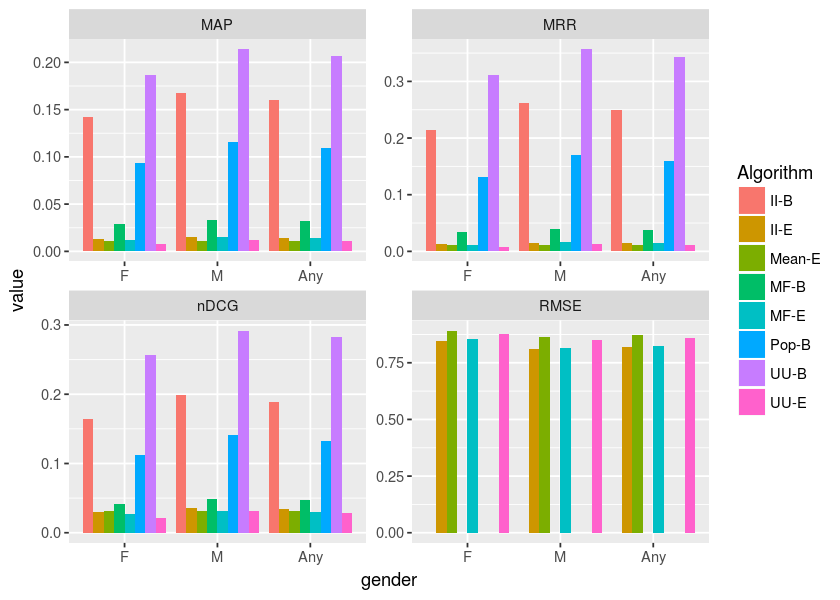

In [24]:
ggplot(combined.results) +
    aes(x=gender, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_wrap(~ Metric, scales="free")

## Age

We now want to examine accuracy as a function of age. We're basically going to do the same thing we did for gender.

Start by aggregating the results:

In [30]:
# FIXME Re-add rank nDCG
age.results = user.results %>%
    select(Algorithm, age, MAP=AvgPrec, MRR=RecipRank, nDCG) %>%
    gather("Metric", "value", -Algorithm, -age) %>%
    group_by(Algorithm, age, Metric) %>%
    summarize(value=mean(value))
age.results

Algorithm,age,Metric,value
II-B,1,MAP,0.1448092
II-B,1,MRR,0.2267504
II-B,1,nDCG,0.1804995
II-B,18,MAP,0.1654056
II-B,18,MRR,0.2635039
⋮,⋮,⋮,⋮
UU-E,50,MRR,0.007145532
UU-E,50,nDCG,0.022216754
UU-E,56,MAP,0.006705764
UU-E,56,MRR,0.006429232


And then we can plot them:

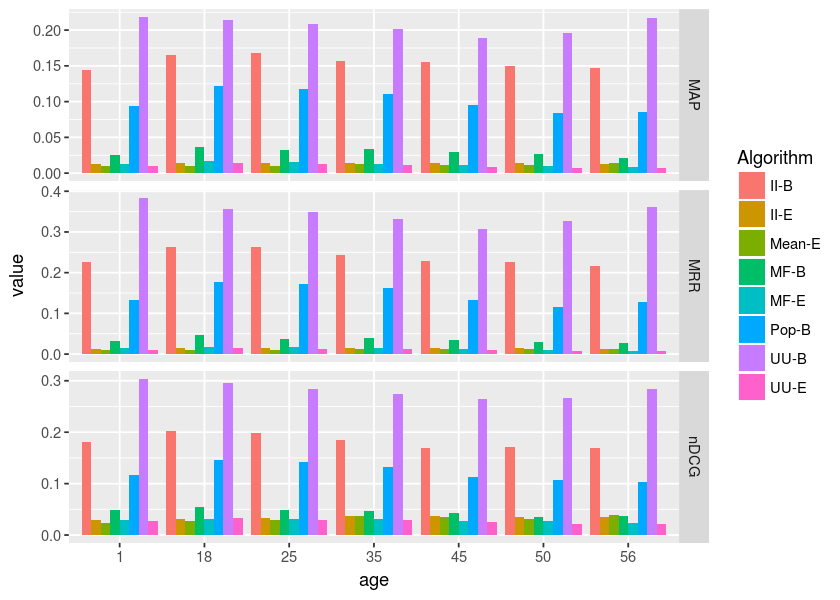

In [31]:
ggplot(age.results) +
    aes(x=age, y=value, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge") +
    facet_grid(Metric ~ ., scales="free_y")

### Controlling for Profile Size

Let's control for profile size again.

In [32]:
age.corr.ndcg = user.results %>%
    select(user, Algorithm, age, nDCG) %>%
    inner_join(select(user.ndcg.preds, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(age, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
head(age.corr.ndcg)

Joining, by = "user"


age,Algorithm,nDCG,Corr.nDCG
1,II-B,0.18049953,0.09327252
1,II-E,0.02916638,-0.05806063
1,Mean-E,0.02325226,-0.06397475
1,MF-B,0.04930430,-0.03792271
1,MF-E,0.02870881,-0.05851821
1,Pop-B,0.11716021,0.02993319


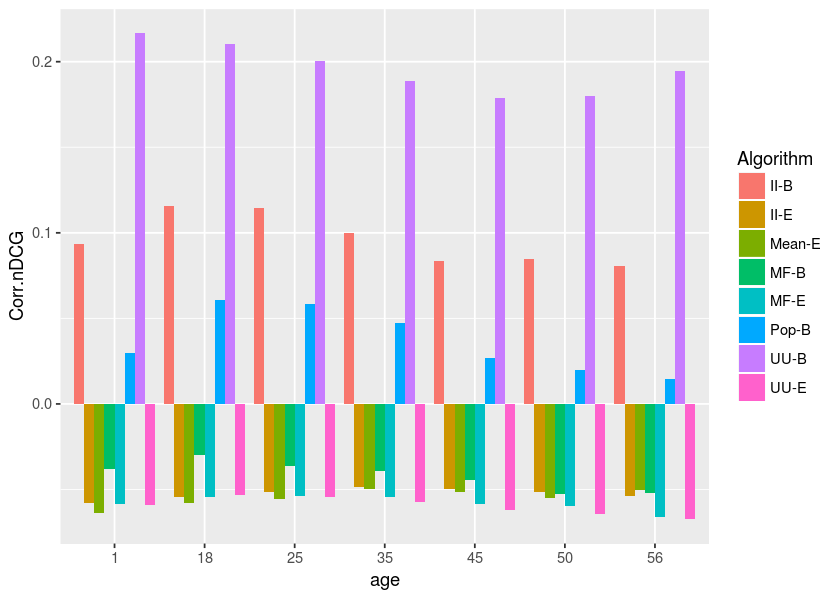

In [33]:
ggplot(age.corr.ndcg) +
    aes(x=age, y=Corr.nDCG, fill=Algorithm) +
    geom_bar(stat="identity", position="dodge")

Discrepancy in performance is robust to controls for size.